In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from analyze_aparent_designed_mpra_helpers import *


<h2>Load collapsed designed MPRA data</h2>

In [2]:
#Load designed MPRA data (Collapsed over experiment replicates)
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
print("n = " + str(len(seq_dict['array_df'])))
print('Avg read count (avg over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['mean_total_count'])))
print('Pooled read count (pooled over barcodes) = ' + str(np.mean(seq_dict['array_df'].query("n_barcodes >= 2")['pooled_total_count'])))

#Load variant dataframe
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df, variant_df = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'])


n = 39833
Avg read count (avg over barcodes) = 431.92676310713546
Pooled read count (pooled over barcodes) = 3656.5562880452626
n (variants) = 21734


<h2>Rare Functional Variant Detailed analysis</h2>

In [3]:
variant_df_filtered = variant_df.query("n_barcodes_var >= 5 and n_barcodes_ref >= 5 and mean_total_count_var >= 200 and mean_total_count_ref >= 200")

#Filter on human variants
included_experiments = ['acmg_apadb', 'acmg_polyadb', 'sensitive_genes', 'clinvar_wt', 'human_variant']

filter_query = ""

for exp_index, included_experiment in enumerate(included_experiments) :
    filter_query += "experiment == '" + str(included_experiment) + "'"
    if exp_index < len(included_experiments) - 1 :
        filter_query += " or "

human_variant_df = variant_df.query(filter_query).copy()
human_variant_df_filtered = variant_df_filtered.query(filter_query).copy()

human_variant_df['delta_logodds_pred'] = human_variant_df['mean_delta_logodds_pred']
human_variant_df_filtered['delta_logodds_pred'] = human_variant_df_filtered['mean_delta_logodds_pred']


var_df = human_variant_df_filtered.query("variant == 'snv' and snv_pos != -1").copy()

mer6_weights_doubledope = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_doubledope_weights.npy')[1:]
mer6_weights_simple = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_simple_weights.npy')[1:]
mer6_weights_tomm5 = np.load('apa_6mer_weights/apa_6mer_v_general3_antimisprime_orig_pasaligned_margin_tomm5_weights.npy')[1:]

mer6_weights_use = (mer6_weights_tomm5[:4096] + mer6_weights_simple[:4096]) / 2.
mer6_weights_pas = mer6_weights_doubledope[4096:2*4096]
mer6_weights_dse = (mer6_weights_tomm5[2*4096:] + mer6_weights_simple[2*4096:]) / 2.

var_df = append_6mer_delta_logodds_scores(var_df, mer6_weights_use, mer6_weights_pas, mer6_weights_dse)
var_df['delta_logodds_pred'] = var_df['mean_delta_logodds_pred']


<h2>DSE Secondary Structure Variants</h2>

In [16]:
#Calculate mean cut position in variant and wildtype DSEs
var_df['avg_pos_true_ref'] = var_df['cut_prob_true_ref'].apply(lambda p: np.sum(np.arange(len(p[57:110])) * (p[57:110] / np.sum(p[57:110]))))
var_df['avg_pos_true_var'] = var_df['cut_prob_true_var'].apply(lambda p: np.sum(np.arange(len(p[57:110])) * (p[57:110] / np.sum(p[57:110]))))

pas_dict = {'AATAAA' : True, 'ATTAAA' : True, 'TATAAA' : True, 'GATAAA' : True, 'CATAAA' : True, 'AGTAAA' : True, 'ACTAAA' : True, 'AAGAAA' : True, 'AGGAAA' : True, 'AACAAA' : True, 'AATAAT' : True}

#Filter out variants creating de novo CSE hexamers in the DSE
#Reason: The shift in cut position is not due to 2ary structure but new CSEs
keep_index = []
i = 0
for _, row in var_df.iterrows() :
    snv_pos = row['snv_pos']

    var_region = row['master_seq'][57:105]
    ref_region = row['wt_seq'][57:105]

    pas_found = False
    for pas in pas_dict :
        if pas in var_region or pas in ref_region :
            pas_found = True
            break

    if not pas_found :
        keep_index.append(i)

    i += 1

var_df_no_pas = var_df.iloc[keep_index].copy()
var_df_no_pas['delta_pos_true'] = var_df_no_pas['avg_pos_true_var'] - var_df_no_pas['avg_pos_true_ref']


In [17]:
#Store/load folded wildtype/variant sequences
#var_df_no_pas[['master_seq', 'wt_seq']].to_csv('folding/array_cut_var_seqs.csv', sep=',')
var_df_no_pas_fold = pd.read_csv('folding/array_cut_var_seqs_folded.csv', sep=',')
var_df_no_pas = var_df_no_pas.join(var_df_no_pas_fold.set_index('master_seq'), on='master_seq', rsuffix='folded')

In [18]:
#Filter variants on large delta MFEs calculated from ViennaRNA fold
keep_index = []

i = 0
for _, row in var_df_no_pas.iterrows() :
    mfe_var = row['mfe_var']
    mfe_ref = row['mfe_wt']
    delta_mfe = row['delta_mfe']
    
    if delta_mfe < -2 and mfe_var < -4.0 :
        keep_index.append(i)
    
    i += 1

var_df_foldchange = var_df_no_pas.iloc[keep_index]


Folding alteration variants:
Gene = MLH1.2
SNV pos = 69
SNV nt = A
ClinVar id = Missing


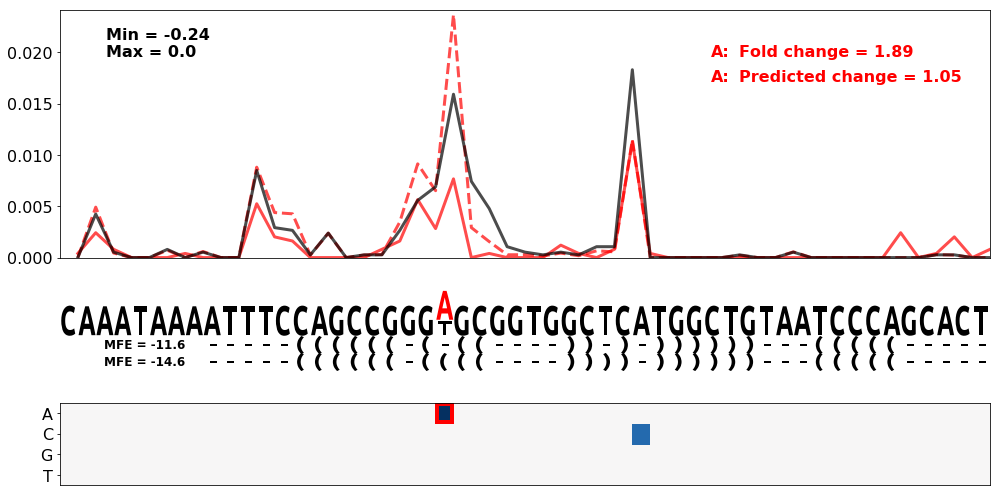

Gene = ARSA.3
SNV pos = 83
SNV nt = G
ClinVar id = Missing


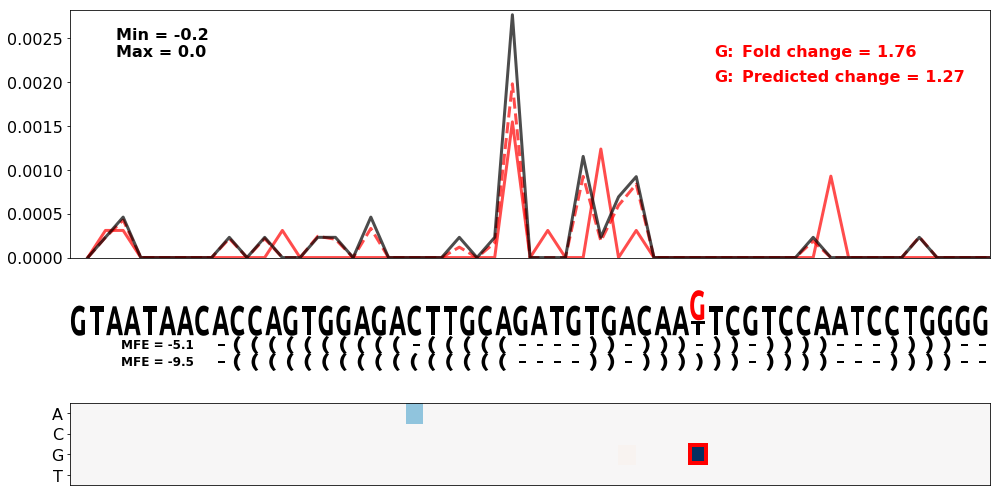

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 76
SNV nt = G
ClinVar id = Missing


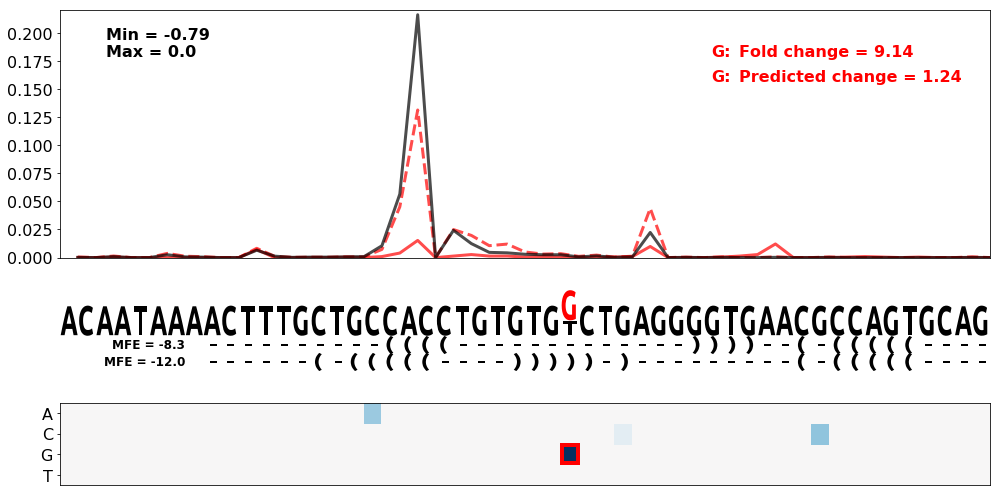

Gene = PTEN.16
SNV pos = 107
SNV nt = G
ClinVar id = Missing


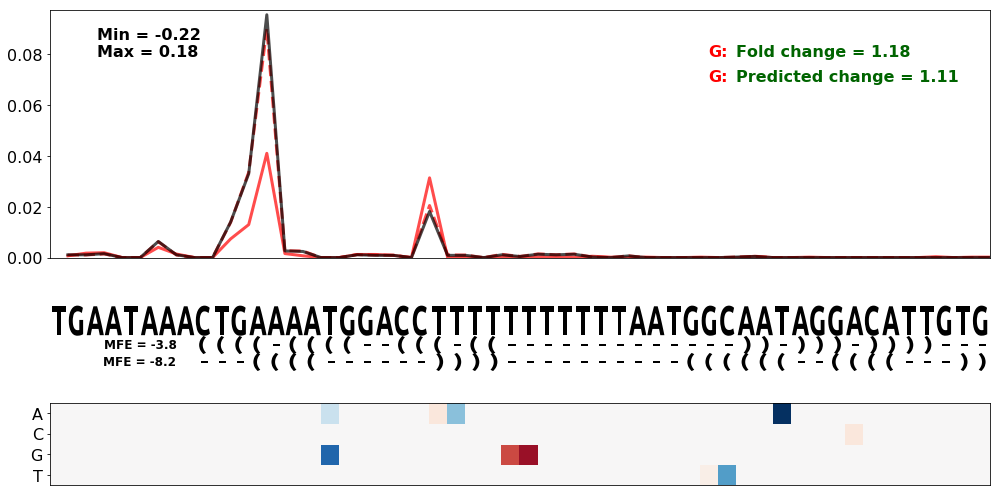

Gene = NF2.3
SNV pos = 97
SNV nt = G
ClinVar id = Missing


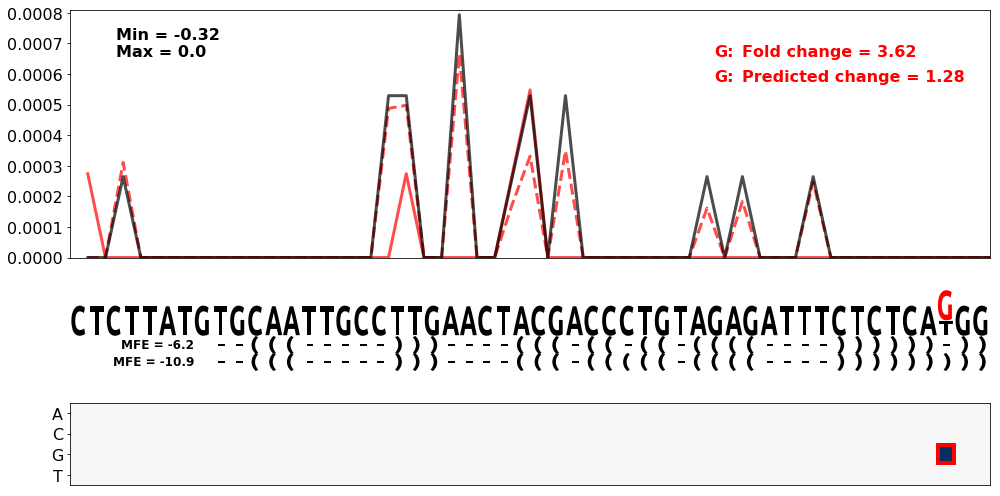

Gene = LDLR.4
SNV pos = 66
SNV nt = G
ClinVar id = Missing


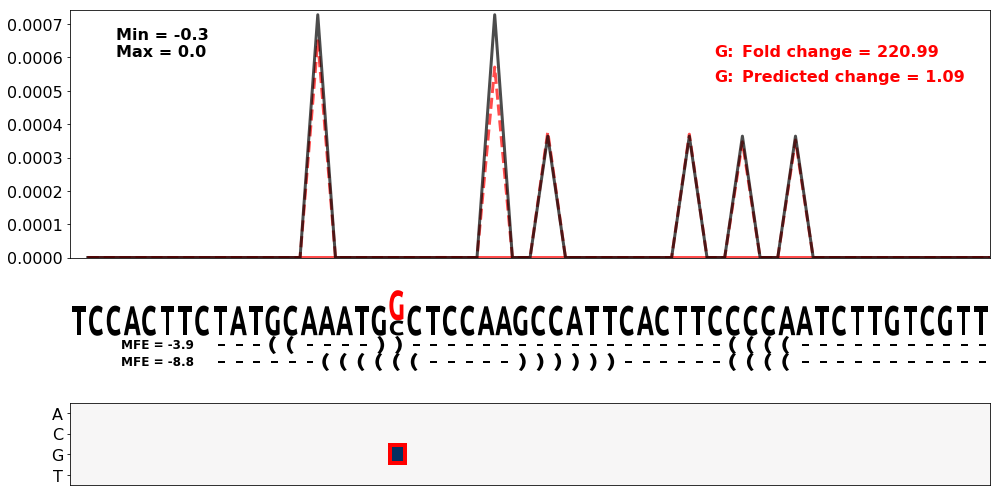

Gene = PEX5.3
SNV pos = 74
SNV nt = C
ClinVar id = NM_001131025.1(PEX5):c.*1259G>C


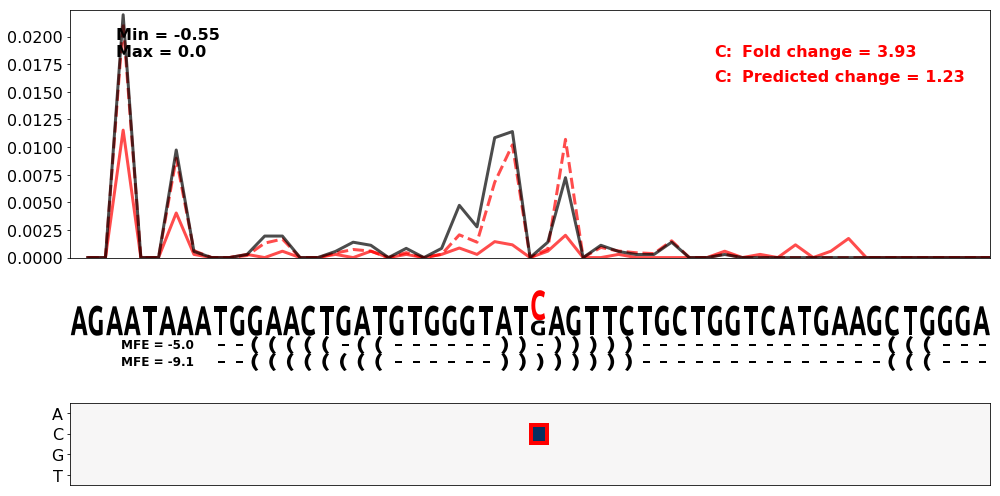

Gene = BRCA1.1
SNV pos = 72
SNV nt = A
ClinVar id = Missing


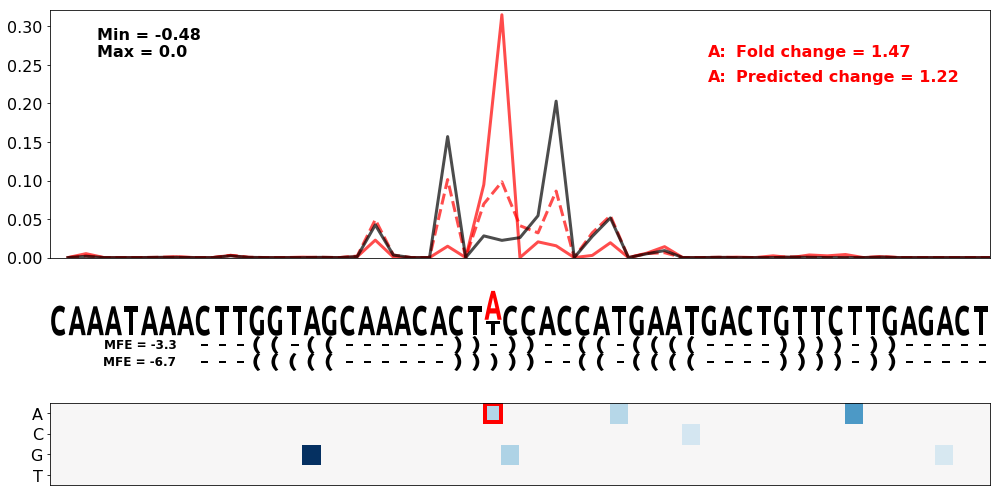

Gene = TP53.3
WT seq = CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG
SNV pos = 65
SNV nt = A
ClinVar id = Missing


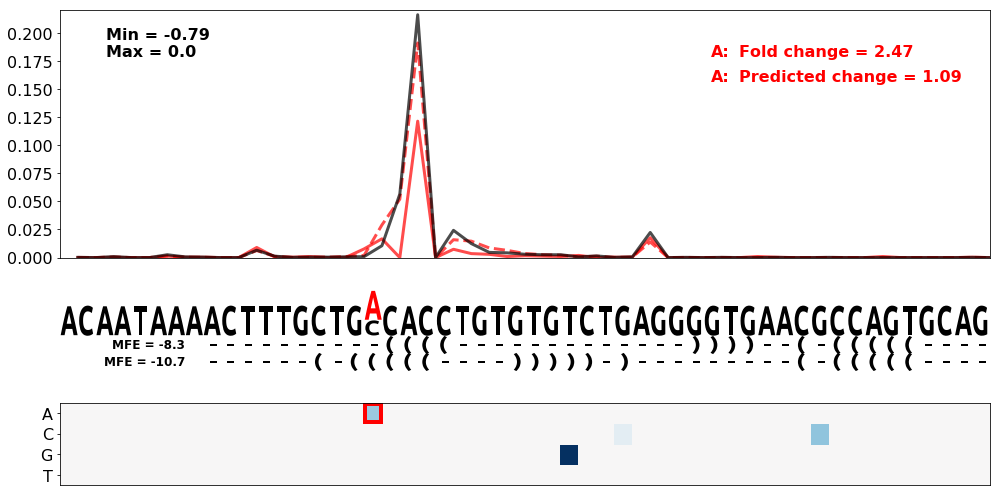

Gene = FRA10AC1.1
SNV pos = 68
SNV nt = G
ClinVar id = NM_006204.3(PDE6C):c.*209T>C


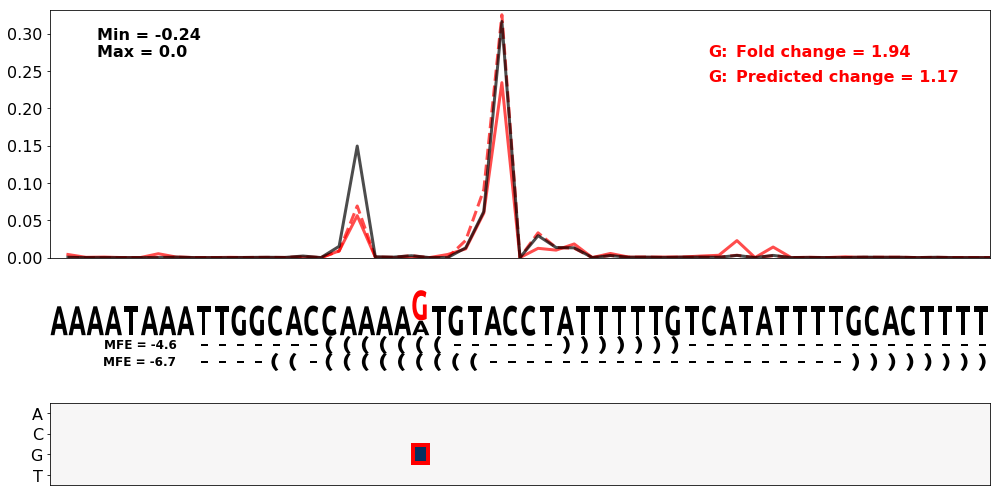

Gene = TGFBR2.3
SNV pos = 68
SNV nt = G
ClinVar id = Missing


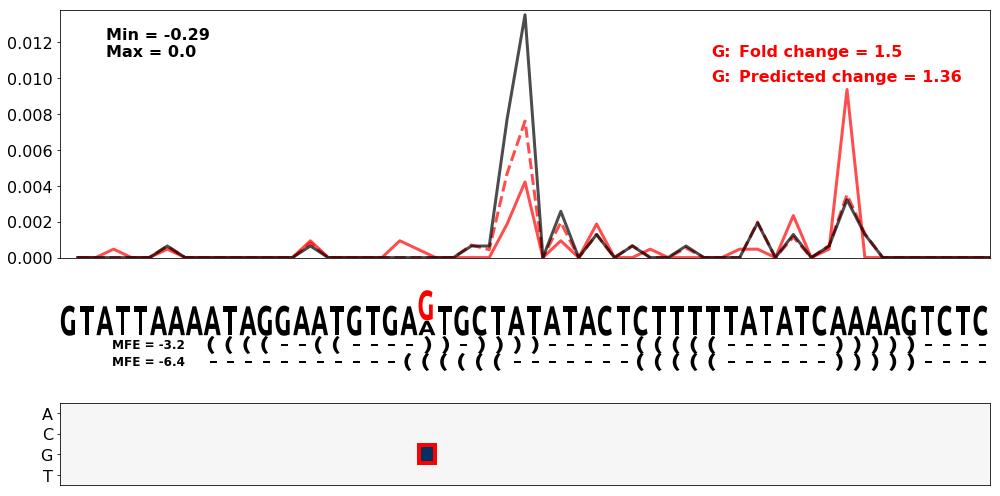

In [19]:
print('Folding alteration variants:')

experiment_name = 'folding'

gene_names = [
    'MLH1.2',
    'ARSA.3',
    'TP53.3',
    'PTEN.16',
    'NF2.3',
    'LDLR.4',
    'PEX5.3',
    'BRCA1.1',
    'TP53.3',
    'FRA10AC1.1',
    'TGFBR2.3'
]

snv_list = [
    [(69, 'A', 'red')],
    [(83, 'G', 'red')],
    [(76, 'G', 'red')],
    [(107, 'G', 'red')],
    [(97, 'G', 'red')],
    [(66, 'G', 'red')],
    [(74, 'C', 'red')],
    [(72, 'A', 'red')],
    [(65, 'A', 'red')],
    [(68, 'G', 'red')],
    [(68, 'G', 'red')]
]

wt_seq_list = [
    None,
    None,
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG',
    None,
    None,
    None,
    None,
    None,
    'CCTCCTTCTCCCTTTTTATATCCCATTTTTATATCGATCTCTTATTTTACAATAAAACTTTGCTGCCACCTGTGTGTCTGAGGGGTGAACGCCAGTGCAGGCTACTGGGGTCAGCAGGTGCAGGGGTGAGTGAGGAGGTGCTGGGAAGCAGCCACCTGAGTCTG',
    None,
    None
]

seq_start = 48
seq_end = 100

save_figs = False

df_to_use = var_df_foldchange.set_index('master_seq')#df_var_no_pas.set_index('master_seq')

for gene_name, snvs, specific_seq in zip(gene_names, snv_list, wt_seq_list) :
    df_sel = df_to_use
    if specific_seq is not None :
        df_sel = df_to_use.query("wt_seq == '" + specific_seq + "'")

    print('Gene = ' + gene_name)
    if specific_seq is not None :
        print('WT seq = ' + specific_seq)
    print('SNV pos = ' + str(snvs[0][0]))
    print('SNV nt = ' + str(snvs[0][1]))
    print('ClinVar id = ' + str(df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['clinvar_id'].values[0]))
    
    struct_var = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['struct_var'].values[0]
    struct_ref = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['struct_wt'].values[0]
    struct_var = ('X' * 56) + struct_var + ('X' * 100)
    struct_ref = ('X' * 56) + struct_ref + ('X' * 100)
    
    mfe_var = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['mfe_var'].values[0]
    mfe_ref = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['mfe_wt'].values[0]
    delta_mfe = df_sel.loc[df_sel.index.str.slice(snvs[0][0], snvs[0][0]+1) == snvs[0][1]].query("gene == '" + gene_name + "' and snv_pos == " + str(snvs[0][0]))['delta_mfe'].values[0]
    
    fig_name = None
    if save_figs :
        fig_name = experiment_name + '_' + gene_name + '_' + str(snvs[0][0]) + '_' + str(snvs[0][1]) + '_Both'
    mut_map_with_cuts_and_fold(
            df_sel,
            gene_name,
            mfe_ref,
            mfe_var,
            struct_ref,
            struct_var,
            snvs,
            mode='true',
            column_suffix='',
            figsize=(14, 7),
            height_ratios=[6, 2, 2],
            bg_alpha=0.999,
            plot_simple_mutmap=True,
            annotate_folds=True,
            plot_true_cuts=True,
            plot_pred_cuts=True,
            scale_pred_cuts=True,
            fold_change_from_cut_range=[60, 100],
            ref_var_scales=[0.5, 1.0],
            border_eta = 0.06,
            seq_trim_start=seq_start, seq_trim_end=seq_end,
            plot_start=0, plot_end=seq_end-seq_start,
            plot_as_bars=False,
            pas_downscaling=0.5,
            fig_name=fig_name,
            fig_dpi=150
    )